# Thomas Fire Impact: Air Quality Index Trends and False Imagery Assessment

### Author: Diana Navarro

GitHub repository: https://github.com/dianaxnav/thomas_fire_analysis

# About

## Purpose 

In 2017, Santa Barbara and Ventura county suffered the 7th largest wildfire in the history of California. Almost 300,000 acres were burned and caused more than 150 million in damages across both counties. The purpose of this repsoitiory is to show the the damages of the Thomas fire in two different ways. We will plot the trend of AQI over a 5 day average to see how it affected the air quality in December of 2017. Next we will map out Santa Barbara County and layer over the Thomas Fire perimeter showing the extent of the land that was burned.  

## Highlights of Analysis 
1. Importing Data 
2. Data Exploration 
3. Data Tidying
4. Vizualizing Data 

## Dataset Description 

#### Air Quality Index 
To properly represent this data, we will be plotting the trend of Air Quality Index (AQI) data. This data is provided by the US Environmental Protection Agency. AQI is the EPA's index for reporting air quality on a scale from 0 ot 500, with O representing a healthy air quality and 500 a hazardous air quality. The first file from 2017 contains 326801 rows and 10 columns, while the second 2018 file shows 327537 rows and 10 columns. This data gives us the AQI in each state, by county and date. We will be combining this data in the `Analysis` section. 


#### False Color Imagery
In order to create the false imagery map, we will need to use two datasets here. One of the datasets is from the Landsat 8 Satellite and provides a collection of bands from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data. This dataset is an `xarray.core.dataset.Dataset` with dimensions of (870, 731, 1). In order to outline the Thomas Fire dataset within the spatial data, we will access a shape file from the California Department of Forestry and Fire protection. This shape file is a geoDataFrame that contains 608 rows and 23 columns. This file shows us the perimeters of the Thomas Fire in 2017 and note the following columns:

     - FIRE_NAME
     - ALARM_DATE
     - YEAR_

## 1. Importing Data

Let's load all the libraries we will potentially use:

In [30]:
#Import all necessary libraries 
import os
import numpy as np

import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

from shapely import Point
import matplotlib.pyplot as plt
import pandas as pd
from shapely import box
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#read in the data using read csv function and store it
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# load landsat nc file (1st dataset)
landsat1 = os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(landsat1)

#load ca fire data using gpd 
cal_fire = gpd.read_file('data/California_Fire_Perimeters_2017')

## 2. Data Exploration

In the next couple cells, we will explore the dataset in order to better understand what we want to do with the data and how we would like to plot it.  

In [31]:
#use the head function to take a look at the first five rows of the aqi data
aqi_17.head()
aqi_18.head()
cal_fire.head()

,index,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,...,GIS_ACRES,COMMENTS,COMPLEX_NA,COMPLEX_IN,IRWINID,FIRE_NUM,DECADES,SHAPE_Leng,SHAPE_Area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,...,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((-13229812.974 4046876.486, -13229786..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,...,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((-13286872.985 4074523.355, -13286895..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,...,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((-13244637.580 4056332.530, -13244620..."
3,19839,41432,2017,CA,CCO,VNC,PACIFICA,00051791,2017-06-24,2017-06-24,...,1.158548,GPS track,None,None,None,None,2010,501.178102,6859.664843,"POLYGON ((-13229521.754 4046254.111, -13229510..."
4,19840,41433,2017,CA,CCO,VNC,MONTVIEW,00040196,2017-05-15,2017-05-15,...,2.893327,Rough per description. waiting for walked GPS...,None,None,None,None,2010,484.388887,17133.006159,"POLYGON ((-13229663.036 4046858.853, -13229667..."


Now that we have checked out and explored all our datasets, lets work on tidying up the dataset and making updates to plot! 

## 3. Data Tidying 


### AQI Data
In this section we will be tidying up AQI data to make it easier to work with for plotting.

In [32]:
#store the the output and use the concat function to join
aqi = pd.concat([aqi_17, aqi_18])

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

#select santa barbara data from county col and store the output 
aqi_sb = aqi[aqi.county_name == 'Santa Barbara']

#remove the cols --don't store this-- keep it as an object
aqi_sb = aqi_sb.drop(columns = ["state_name", "county_name", "state_code", "county_code"])

#update the date col to be a datetime object
aqi_sb['date'] = pd.to_datetime(aqi_sb.date)

#set the index to date col
aqi_sb.set_index('date', inplace = True)

#use rolling to find the mean over a five day period
aqi_sb.aqi.rolling('5D').mean()

# add column w/5-day rolling average
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()


### Fire Perimeter data 

Tidy up the data for the fire perimeter 

In [33]:
#lets drop the band using `squeeze()` 
landsat = landsat.squeeze().drop('band')

#check to see if the crs matches
cal_fire.crs == landsat.rio.crs

# Set the new CRS to make it equal to landsat
cal_fire = cal_fire.to_crs(landsat.rio.crs)

#select thomas fire data only to plot it 
thomas_fire = cal_fire[cal_fire['FIRE_NAME'] == 'THOMAS']

## 4.Visualizing the data

### Daily AQI and 5-day Average

Let's make a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI). Then let's update the title and colors of the graph. Can you see the AQI going up during the Thomas Fire in December 2017?

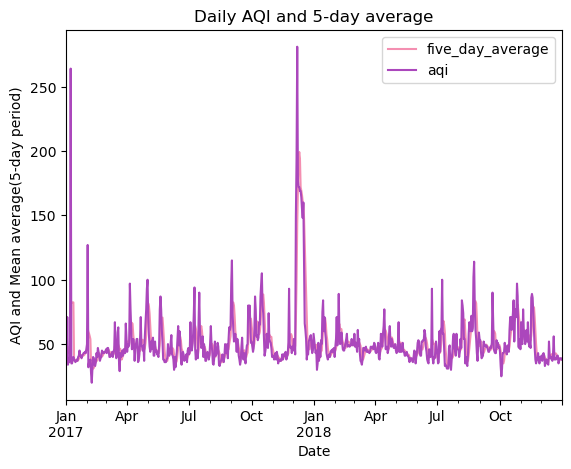

In [34]:
#it already knows to plot the date index so no need to call x
aqi_sb.plot(y=['five_day_average', 'aqi'], #call the y values 
        title = 'Daily AQI and 5-day average',
        xlabel='Date',
        ylabel='AQI and Mean average(5-day period)',  #label      
        color = {'five_day_average':'#F48FB1',
                 'aqi': '#AB47BC' #customize color
                 }
           )

# save figure
plt.savefig('dailyaqi_5day.png', bbox_inches='tight',  dpi=100)

**In the graph you could see the spike of aqi right in December 2017 when the Thomas fire occured, where it peaks just above 250.**

### Thomas Fire in Santa Barbara County

Let's create a map showing the shortwave infrared/nir/red false color image together with the Thomas fire perimeter.  

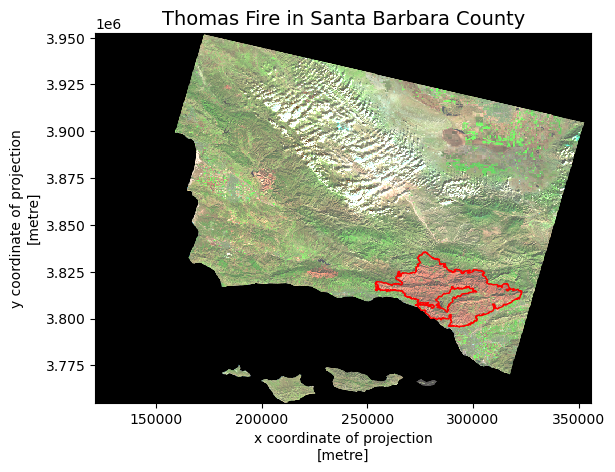

In [35]:
#create false imagery and call the variables
fig, ax = plt.subplots()
thomas_fire.plot(ax = ax, 
                 color = "None",
                edgecolor = "red")

#plot the show the data 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

#set the title of the map 
ax.set_title('Thomas Fire in Santa Barbara County', fontsize = 14)

# save figure
plt.savefig('thomasfire.png', bbox_inches='tight',  dpi=100)

### Analyzing the Impact of the Thomas Fire 

**With the plot shown above, we can see visualize the area that was affected by the Thomas Fire. The plot showing the daily AQI and five day average gives us better insight on the impact it took on the air quality.**

## References to Datasets 

AirNow. (2021b). Air Quality Index (AQI) Basics. Retrieved from www.airnow.gov website: https://www.airnow.gov/aqi/aqi-basics/ 

California Fire Perimeters (all). (n.d.). Retrieved November 29, 2023, from gis.data.ca.gov website: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

Microsoft Planetary Computer. Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2))

USGS. (n.d.). What are the band designations for the Landsat satellites? | U.S. Geological Survey. Retrieved from www.usgs.gov website: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites